In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
from keras.utils import Sequence
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
from keras.callbacks import TensorBoard
from keras.models import model_from_json
from sklearn.model_selection import train_test_split
%matplotlib inline

import glob
import imageio
import pandas as pd
from os import listdir
from datetime import timezone, datetime

Using TensorFlow backend.


# Initialize

## Define constant variable
- data_dir : root directory for date
- label_file : location of label file
- history_csv : location of history output file
- model_file : location of model output file
- weight_file : locaiton of weight output file

## Checking processor
Checking CPU and GPU available

In [2]:
candidate = ['Black', 'White', 'Edge']
# input
label_file = '../../DATASET/Black/label.csv'
data_dir = {
    'Black': '../../DATASET/Black/data/',
    'White': '../../DATASET/White/data/',
    'Edge': '../../DATASET/Edge/data/',
}

# output
timestamp = int(datetime.now().timestamp()*1000)
history_csv = {
    'Black': './results/history_black_{}.csv'.format(timestamp),
    'White': './results/history_white_{}.csv'.format(timestamp),
    'Edge': './results/history_edge_{}.csv'.format(timestamp),
}
confusion_csv = {
    'Black': './results/confusion_black_{}.csv'.format(timestamp),
    'White': './results/confusion_white_{}.csv'.format(timestamp),
    'Edge': './results/confusion_edge_{}.csv'.format(timestamp),
}
model_file = {
    'Black': './models/model_black_{}.json'.format(timestamp),
    'White': './models/model_white_{}.json'.format(timestamp),
    'Edge': './models/model_edge_{}.json'.format(timestamp),
}
weight_file = {
    'Black': './models/weight_black_{}.h5'.format(timestamp),
    'White': './models/weight_white_{}.h5'.format(timestamp),
    'Edge': './models/weight_edge_{}.h5'.format(timestamp),
}
log_tb = './logs/tensorboard/{}/'.format(timestamp)
histories = {
    'Black': [],
    'White': [],
    'Edge': [],
}

# config training
batch_size = 5
num_epochs = 10
learning_rate = 0.0005

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12760206621155695468
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3215668019
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3560574229177535055
physical_device_desc: "device: 0, name: GeForce GTX 950M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


# Prepare Model
create simple model for CNN

In [3]:
def create_model() :
    model = Sequential()

    # Convolution
    ## 5x5 convolution with 2x2 stride and 32 filters
    model.add(Conv2D(32, (5, 5), strides = (4, 4), padding='same',
                     input_shape=(3000, 3000, 1)))
    model.add(Activation('relu'))

    ## 2x2 max pooling reduces to 3 x 3 x 32
    model.add(MaxPooling2D(pool_size=(4, 4)))

    ## Another 5x5 convolution with 2x2 stride and 32 filters
    model.add(Conv2D(32, (5, 5), strides = (4, 4)))
    model.add(Activation('relu'))

    ## 2x2 max pooling reduces to 3 x 3 x 32
    model.add(MaxPooling2D(pool_size=(4, 4)))

    ## Flatten turns 3x3x32 into 288x1
    model.add(Flatten())

    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    model.add(Dense(2))
    model.add(Activation('sigmoid'))

    return model

In [4]:
models = {
    'Black': create_model(),
    'White': create_model(),
    'Edge': create_model()
}
models['Black'].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 750, 750, 32)      832       
_________________________________________________________________
activation_1 (Activation)    (None, 750, 750, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 187, 187, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        25632     
_________________________________________________________________
activation_2 (Activation)    (None, 46, 46, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3872)              0         
__________

# Prepare data
## Prepare label and input file name

In [5]:
df  = pd.read_csv(label_file, index_col=0)
image_black = pd.Series(data_dir['Black'] + df.image, name='img_black')
image_white = pd.Series(data_dir['White'] + df.image, name='img_white')
image_edge = pd.Series(data_dir['Edge'] + df.image, name='img_edge')
df = pd.concat([df, image_black, image_white, image_edge], axis=1)
df.head()

,image,label,img_black,img_white,img_edge
0,1.jpg,0,../../DATASET/Black/data/1.jpg,../../DATASET/White/data/1.jpg,../../DATASET/Edge/data/1.jpg
1,2.jpg,0,../../DATASET/Black/data/2.jpg,../../DATASET/White/data/2.jpg,../../DATASET/Edge/data/2.jpg
2,3.jpg,0,../../DATASET/Black/data/3.jpg,../../DATASET/White/data/3.jpg,../../DATASET/Edge/data/3.jpg
3,4.jpg,0,../../DATASET/Black/data/4.jpg,../../DATASET/White/data/4.jpg,../../DATASET/Edge/data/4.jpg
4,5.jpg,0,../../DATASET/Black/data/5.jpg,../../DATASET/White/data/5.jpg,../../DATASET/Edge/data/5.jpg


## Split data set
split data to train(70%), val(15%) and test(15%) set

In [6]:
# Split - train:70, val:15, test:15
x_train_idx, x_test_idx, y_train, y_test = train_test_split(df.index, df.label, test_size=0.30)
x_val_idx, x_test_idx, y_val, y_test = train_test_split(x_test_idx, y_test, test_size=0.50)

x_train = {
    'Black': df.loc[x_train_idx].img_black,
    'White': df.loc[x_train_idx].img_white,
    'Edge': df.loc[x_train_idx].img_edge
}
x_val = {
    'Black': df.loc[x_val_idx].img_black,
    'White': df.loc[x_val_idx].img_white,
    'Edge': df.loc[x_val_idx].img_edge
}
x_test = {
    'Black': df.loc[x_test_idx].img_black,
    'White': df.loc[x_test_idx].img_white,
    'Edge': df.loc[x_test_idx].img_edge
}

## Create data generator
create data generator for query data from data set

In [7]:
class DataGenerator(Sequence) :
    def __init__(self, x, y, batch_size) :
        self.x = x
        self.y = keras.utils.to_categorical(y, 2)
        self.batch_size = batch_size
        
    def __len__(self) :
        return int(np.ceil(len(self.x) / float(self.batch_size)))
    
    def __getitem__(self, idx) :
        # get all data in batch number idx
        start = idx * self.batch_size
        end = (idx+1) * self.batch_size
        names = self.x.iloc[start : end]
        
        batch_x = np.array([ np.array(imageio.imread(f, pilmode='L')).reshape((3000, 3000, 1)) for f in names])
        batch_x = batch_x.astype('float16')
        batch_x /= 255
        batch_y = np.array(self.y[start: end])
        return batch_x, batch_y

In [8]:
train_generator = dict()
val_generator = dict()
test_generator = dict()
for can in candidate:
    train_generator[can] = DataGenerator(x_train[can], y_train, batch_size) 
    val_generator[can] = DataGenerator(x_val[can], y_val, batch_size)
    test_generator[can] = DataGenerator(x_test[can], y_test, batch_size)

# Training model
traing model with training set and validate set

In [9]:
for can in candidate:
    print('Trainning', can)
    model = models[can]
    opt = keras.optimizers.rmsprop(lr=learning_rate, decay=1e-6)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    tensorboard = TensorBoard(log_dir=log_tb)

    histories[can] = model.fit_generator(generator=train_generator[can],
                                              steps_per_epoch=(len(train_generator[can]) // batch_size),
                                              epochs=num_epochs,
                                              verbose=1,
                                              validation_data=val_generator[can],
                                              validation_steps=(len(val_generator[can]) // batch_size),
                                              callbacks=[tensorboard])

Trainning Black
Epoch 1/10
164/164 [==============================] - 207s 1s/step - loss: 0.4673 - acc: 0.7951 - val_loss: 0.3292 - val_acc: 0.8514
Epoch 2/10
164/164 [==============================] - 193s 1s/step - loss: 0.3465 - acc: 0.8512 - val_loss: 0.3629 - val_acc: 0.8629
Epoch 3/10
164/164 [==============================] - 186s 1s/step - loss: 0.3419 - acc: 0.8659 - val_loss: 0.2163 - val_acc: 0.9486
Epoch 4/10
164/164 [==============================] - 182s 1s/step - loss: 0.3018 - acc: 0.8939 - val_loss: 0.2482 - val_acc: 0.9371
Epoch 5/10
164/164 [==============================] - 185s 1s/step - loss: 0.2655 - acc: 0.9012 - val_loss: 0.3103 - val_acc: 0.9429
Epoch 6/10
164/164 [==============================] - 193s 1s/step - loss: 0.2718 - acc: 0.9134 - val_loss: 0.1973 - val_acc: 0.9191
Epoch 7/10
164/164 [==============================] - 191s 1s/step - loss: 0.2422 - acc: 0.9256 - val_loss: 0.4156 - val_acc: 0.8629
Epoch 8/10
164/164 [==============================] -

## plot loss and acc graph

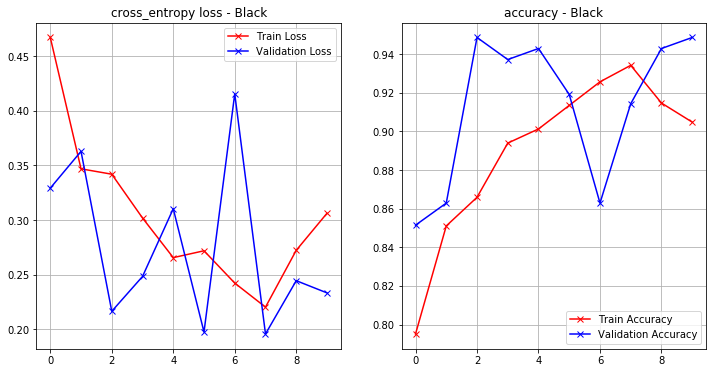

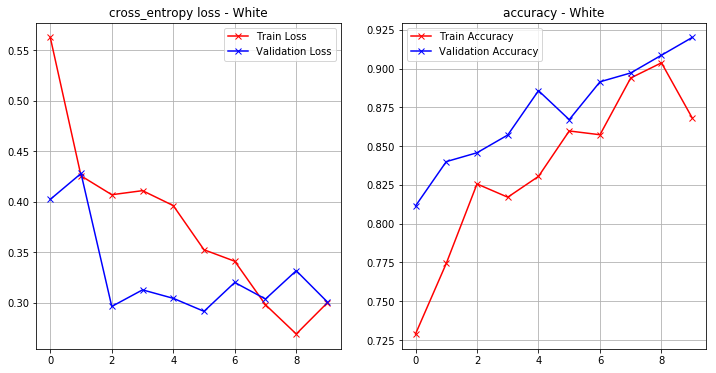

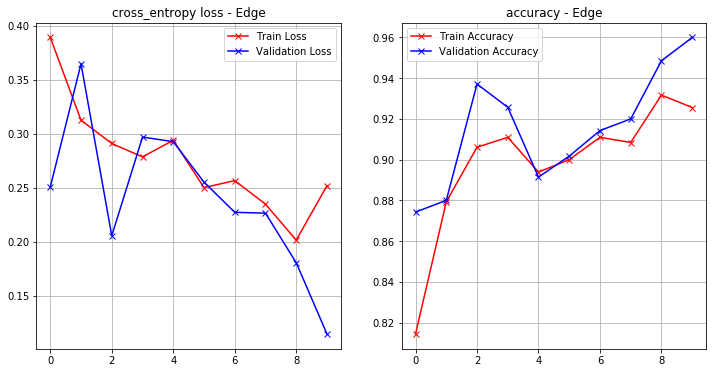

In [10]:
def plot_loss_accuracy(history, name):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('cross_entropy loss - ' + name)
    ax.grid(True)


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["acc"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_acc"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('accuracy - ' + name)
    ax.grid(True)
    
for can in candidate:
    history = histories[can]
    plot_loss_accuracy(history, can)

# Save model
- save model to .json file
- save weight to .h5 file
- save history to .csv file

In [11]:
for can in candidate:
    model = models[can]
    model_json = model.to_json()
    with open(model_file[can], "w+") as json_file:
        json_file.write(model_json)
    model.save_weights(weight_file[can])

In [12]:
for can in candidate :
    history = histories[can]
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(history_csv[can])
    print(history_df)

   val_loss   val_acc      loss       acc
0  0.329195  0.851429  0.467264  0.795122
1  0.362887  0.862857  0.346880  0.851038
2  0.216339  0.948571  0.341948  0.865854
3  0.248221  0.937143  0.301819  0.893902
4  0.310307  0.942857  0.265495  0.901220
5  0.197317  0.919075  0.271769  0.913415
6  0.415592  0.862857  0.242167  0.925610
7  0.195527  0.914286  0.220137  0.934146
8  0.244363  0.942857  0.272197  0.914634
9  0.233186  0.948571  0.306148  0.904762
   val_loss   val_acc      loss       acc
0  0.402370  0.811429  0.562678  0.728938
1  0.427982  0.840000  0.425642  0.774390
2  0.296324  0.845714  0.406971  0.825610
3  0.312749  0.857143  0.410993  0.817073
4  0.304381  0.885714  0.396209  0.830488
5  0.291504  0.867052  0.352457  0.859756
6  0.320090  0.891429  0.341099  0.857317
7  0.303705  0.897143  0.298020  0.893902
8  0.331727  0.908571  0.269081  0.903659
9  0.301163  0.920000  0.299606  0.868132
   val_loss   val_acc      loss       acc
0  0.250596  0.874286  0.389196  0

# Eavalute
## predict Y
predict Y with test set

In [13]:
# predict
y_pred = dict()
for can in candidate:
    _y_pred = model.predict_generator(test_generator[can], verbose=1)
    y_pred[can] = _y_pred.argmax(axis=1)

176/176 [==============================] - 196s 1s/step


## Confusion matrix
calculate confusion matrix and accuracy

In [14]:
def cal_confusion_matrix(y_test, y_pred):
    result_df = pd.concat([y_test.reset_index(), pd.Series(y_pred, name='predict')], axis=1)
    false_positive_df = result_df[(result_df.predict - result_df.label) == 1]
    false_negative_df = result_df[(result_df.predict - result_df.label) == -1]
    true_positive_df = result_df[((result_df.predict - result_df.label) == 0) & (result_df.label == 1)]
    true_negative_df = result_df[((result_df.predict - result_df.label) == 0) & (result_df.label == 0)]

    ap = len(result_df[result_df.label == 1]) # all positive label
    an = len(result_df[result_df.label == 0]) # all negative label

    fp = len(false_positive_df)
    fn = len(false_negative_df)
    tp = len(true_positive_df)
    tn = len(true_negative_df)
    tr = tp+tn

    # calculate percent from expect label
    fp_percent = fp / an
    fn_percent = fn / ap
    tp_percent = tp / ap
    tn_percent = tn / an
    tr_percent = tr / len(result_df)
    total = len(result_df)

    confusion_mat = pd.DataFrame({'false_positive': [fp, fp_percent],
                                                  'false_negative': [fn, fn_percent],
                                                  'true_positive': [tp, tp_percent],
                                                  'true_negative': [tn, tn_percent],
                                                  'true_result':[tr, tr_percent],
                                                  'total': [total, 1.0]}, index=['amount', 'percent_group'])
    return confusion_mat

In [15]:
for can in candidate:
    confusion_mat = cal_confusion_matrix(y_test, y_pred[can])
    confusion_mat.to_csv(confusion_csv[can])
    confusion_mat

In [16]:
# import matplotlib.ticker as ticker
# import matplotlib.cm as cm
# import matplotlib as mpl
# from matplotlib.gridspec import GridSpec

# def plot_confusion
# # Make square figures and axes
# plt.figure(1, figsize=(20,10))
# the_grid = GridSpec(2, 2)


# cmap = plt.get_cmap('Spectral')
# colors = [cmap(i) for i in np.linspace(0, 1, 8)]


# plt.subplot(the_grid[0, 1], aspect=1, title='Source of Pies')

# source_pie = plt.pie([tp, fn, tn, fp], labels=['tp', 'tn', 'fp', 'fn'], autopct='%1.1f%%', colors=colors)

# plt.suptitle('Pie Consumption Patterns in the United States', fontsize=16)

# plt.show()

In [17]:
# load json and create model

# json_file = open(model_file, 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights(weight_file)
# print("Loaded model from disk")

# opt = keras.optimizers.rmsprop(lr=0.0005, decay=1e-6)
# loaded_model.compile(loss='categorical_crossentropy',
#               optimizer=opt,
#               metrics=['accuracy'])
# result = loaded_model.evaluate_generator(test_generator, verbose=1)